## 1.0 Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 2.0 Load the dataset

In [7]:
df = pd.read_csv(r'dataset/data.csv')

## 3.0 Preparing the dataset

### 3.1 Renaming the columns

In [8]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

### 3.2 Normalizing string values

In [10]:
string_columns = list(df.dtypes[df.dtypes=='object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

## 4.0 Target variable analysis

### 4.1 Target variable visualization

Text(0.5, 1.0, 'MSRP distribution (only MSRP<10e4)')

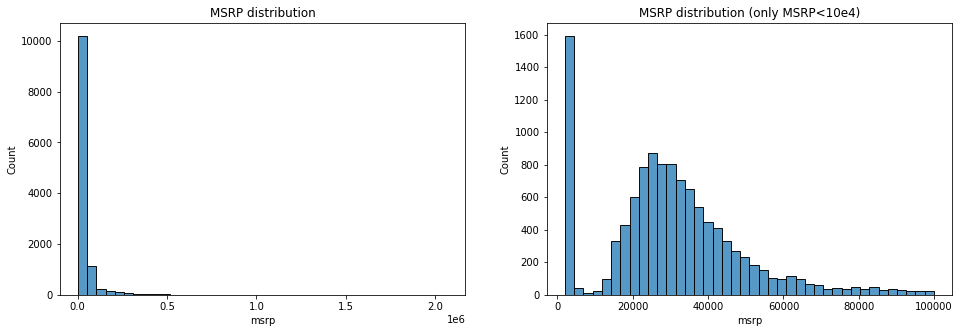

In [21]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'msrp'

sns.histplot(x=col, data=df, ax=ax[0], bins=40)
sns.histplot(x=col, data=df[df[col]<10e4], ax=ax[1], bins=40);

ax[0].set_title('MSRP distribution')
ax[1].set_title('MSRP distribution (only MSRP<10e4)')

### 4.2 Target variable transformation

In [22]:
log_price = np.log1p(df['msrp'])

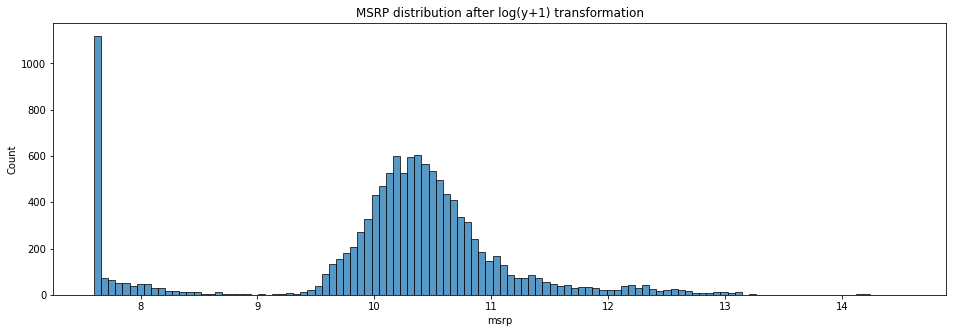

In [26]:
plt.subplots(figsize=(16,5))
sns.histplot(log_price)
plt.title('MSRP distribution after log(y+1) transformation');

## 5.0 Checking for missing values

In [27]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

## 6.0 Validation framework

### 6.1 Train, validation, test data split

In [28]:
n = len(df)

In [29]:
n_val = int(0.2*n)
n_test = int(0.2*n)
n_train = n - (n_val + n_test)

In [32]:
np.random.seed(42)
idx = np.arange(n)
np.random.shuffle(idx)

In [34]:
df_shuffled = df.iloc[idx]

In [36]:
df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

### 6.2 Log transformation

In [37]:
y_train = np.log1p(df_train['msrp'].values)
y_val = np.log1p(df_val['msrp'].values)
y_test = np.log1p(df_test['msrp'].values)

In [38]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

## 7.0 Machine learning for regression

### 7.1 Linear Regression (Normal Equations)

In [39]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:]

### 7.2 Predicting the price

#### 7.2.1 Baseline solution

* Feature selection

In [40]:
base = ['engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg', 'popularity']
df_num = df_train[base]

* Replace NAN values with zero

In [41]:
df_num = df_num.fillna(0)

* Training the LR model

In [43]:
X_train = df_num.values
w_0, w = train_linear_regression(X_train, y_train)

* Make predictions

In [44]:
y_pred = w_0 + X_train.dot(w)

* Predictions Analisys

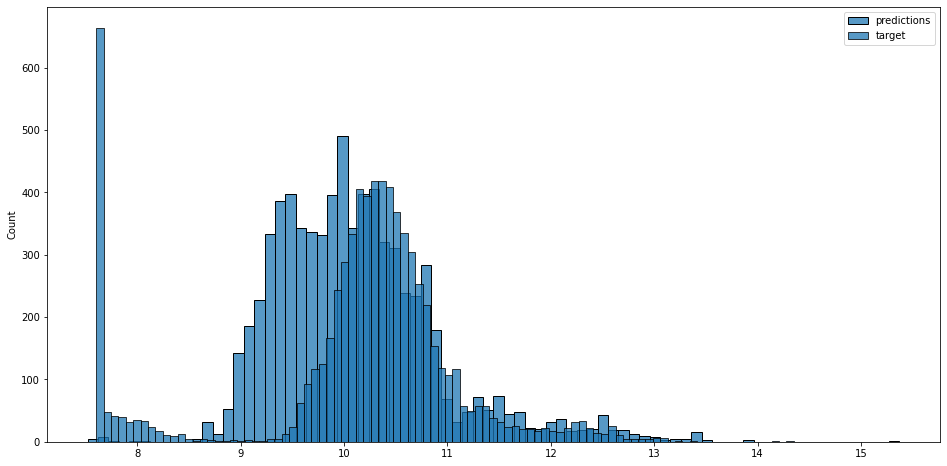

In [48]:
plt.subplots(figsize=(16,8))

sns.histplot(y_pred, label='predictions')
sns.histplot(y_train, label='target')

plt.legend();

### 7.3 RMSE

In [49]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [51]:
rmse(y_train, y_pred)

0.7570200472453602

### 7.4 Validating the model

In [52]:
df_num = df_val[base]
df_num = df_num.fillna(0)
X_val = df_num.values

In [53]:
y_pred = w_0 + X_val.dot(w)

In [54]:
rmse(y_val, y_pred)

0.7398184285113428

In [55]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [56]:
X_train = prepare_X(df_train)
w_0, w = train_linear_regression(X_train, y_train)

In [57]:
X_val = prepare_X(df_val)
y_pred = w_0 + X_val.dot(w)

print('validation:', rmse(y_val, y_pred))

validation: 0.7398184285113428


### 7.5 Feature engineering